In [1]:
import os
from pathlib import Path
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import torchaudio

import IPython.display as ipd
import librosa
import librosa.display

os.chdir("/home/ebbarbera/ade_daic_woz")

PARAMS = {
    "time_sep_speaker": 2,
    "sample_time_len": 4,
    "sr": 16000,
    "stft": {"n_fft": 400,
             "hop_length": 200
             },
    "n_mels": 80,
    "model": {'batch_size': 64,
              'n_epochs': 1000,
              'shuffle': True,
              'activation': 'elu',
              'dense_units': 128,
              'dropout': 0.2,
              'learning_rate': 0.001,
              'early_stopping': 20,
              'optimizer': 'Adam',
              },
}


In [2]:
"""
Utils functions
"""

def show_waveform(audio, participant_id=None, png_path=None):
    """
    Plot and save if desired png of audio waveform.
    """
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(audio, alpha=0.5)
    if participant_id:
        plt.title(f"participant {participant_id}")
    if png_path:
        plt.savefig(png_path)
    plt.show()


def show_spectrogram(im_matrix, participant_id=None, png_path=None, y_axis="linear", sr=16000):
    """
    Plot and save if desired png of spectrogram.
    """
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(im_matrix, x_axis='time', y_axis=y_axis, sr=sr)
    plt.colorbar(format="%+2.f")
    if participant_id:
        plt.title(f"participant {participant_id}")
    if png_path:
        plt.savefig(png_path)
    plt.show()


In [3]:
"""
Utils classes
"""

class Fragment:
    """
    Represents an interview fragment
    """
    def __init__(self, participant_id, audio_times=None, spec_frames=None, stft_mel=True,
                 audios_path="data/raw/audio", device="cuda"):
        """
        Args:
            participant_id (int): participant identifier
            audio_times (tuple): contains the start and stop times in the fragment audio
            spec_frames (tuple): contains the start and stop frames in the fragment spectrogram
            stft_mel (bool): use mel STFT transformation if True, classical STFT is applied otherwise
            audios_path (string): path where audios have been saved
            device (string): type of device to perform torch operations
        """
        if not audio_times and not spec_frames:
            raise Exception("At least one of 'audio_frames' or 'spec_frames' value must be provided")
        self.stft_params = PARAMS["stft"]
        self.audio_times = audio_times
        if not self.audio_times:
            self.audio_times = (librosa.frames_to_times(f, sr=PARAMS["sr"], **self.stft_params) for f in spec_frames)
        self.audio_frames = (librosa.times_to_samples(t, sr=PARAMS["sr"]) for t in self.audio_times)
        self.spec_frames = spec_frames
        if not self.spec_frames:
            self.spec_frames = (librosa.samples_to_frames(f, **self.stft_params) for f in self.audio_frames)
        self.participant_id = participant_id
        self.device = device
        self.stft_params = PARAMS["stft"]
        if stft_mel:
            self.stft_transformation = torchaudio.transforms.MelSpectrogram(**self.stft_params).to(self.device)
        else:
            self.stft_transformation = torchaudio.transforms.Spectrogram(**self.stft_params).to(self.device)
        self.audio_path = Path(audios_path, f"{self.id}_AUDIO.wav")

    def get_audio(self, frames=None, times=None):
        if not frames:  # convert time to frame if provided or set them to default otherwise
            frames = (librosa.time_to_samples(t, sr=PARAMS["sr"]) for t in times) if times else self.audio_frames
        frames = (self.audio_frames[0] + f for f in frames)  # map to the correct audio frame
        if frames[0] < self.audio_frames[0] or frames[1] > self.audio_frames[1]:  # check inputs are not out the scope
            raise Exception(f"Out of the limits start: {self.audio_frames[0]} and end: {self.audio_frames[1]} frames")
        return torchaudio.load(self.audio_path, frame_offset=frames[0], num_frames=frames[1]-frames[0])

    def get_interactive_audio(self, frames=None, times=None):
        audio, sr = self.get_audio(frames, times)
        return ipd.Audio(audio, rate=sr)

    def show_waveform(self, frames=None, times=None, png_path=None):
        audio, sr = self.get_audio(frames, times)
        show_waveform(audio, self.participant_id, png_path)
        return audio, sr

    def get_spectrogram(self, audio_frames=None, audio_times=None, spec_frames=None):
        if not audio_frames and not audio_times:  # convert spec frames to audio frames
            audio_frames = (librosa.frames_to_samples(f, sr=PARAMS["sr"], **PARAMS["stft"]) for f in spec_frames)
        audio, _ = self.get_audio(audio_frames, audio_times)
        spec = self.stft_transformation(audio)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)  # TODO: check spec log y scale
        return spec

    def show_spectrogram(self, audio_frames=None, audio_times=None, spec_frames=None, png_path=None):
        spec = self.get_spectrogram(self, audio_frames, audio_times, spec_frames)
        show_spectrogram(spec.numpy()[0], self.participant_id, png_path)
        return spec


class Participant(Fragment):
    """
    Represents a fragment consisted in a complete interview
    """
    def __init__(self, idx, stft_mel=True, metadata_path="data/raw/labels/metadata.csv",
                 audios_path="data/raw/audio", transcripts_path="data/raw/transcripts", device="cuda"):
        """
        Args:
            idx (int): participant identifier
            transcripts_path (string): path where transcripts have been saved
        """
        audio_times = 0, librosa.get_duration(filename=self.audio_file_path)
        super().__init__(idx, audio_times=audio_times, stft_mel=stft_mel, audios_path=audios_path, device=device)
        self.id = self.participant_id
        self.metadata = pd.read_csv(metadata_path, index_col="Participant_ID").loc[self.participant_id]
        self.partition = self.metadata["split"]
        self.label = self.metadata["PHQ8_Binary"]
        self.score = self.metadata["PHQ8_Score"]
        self.transcript_path = Path(transcripts_path, f"{self.id}_AUDIO.wav")

    def get_transcript(self, times=None):
        transcript = pd.read_csv(self.transcript_path, index_col="Participant_ID")
        times = (self.audio_times[0] + t for t in times) if times else self.audio_times # map to the correct audio sec
        if times[0] < self.audio_times[0] or times[1] > self.audio_times[1]:  # check inputs are not out the scope
            raise Exception(f"Out of the limits start: {self.audio_times[0]} and end: {self.audio_times[1]} frames")
        return transcript.loc[["start_time"] < times[0] & transcript["stop_time"] < times[1]].reset_index(drop=True)


class Segment(Fragment):
    """
    Represents a fragment consisted in a segment from an interview
    """
    def __init__(self, participant_id, idx, stft_mel=True, metadata_path="data/raw/labels/metadata.csv",
                 audios_path="data/raw/audio", transcripts_path="data/raw/transcripts", device="cuda"):
        """
        Args:
            participant_id (int): participant identifier
            idx (int): segment identifier
        """
        self.id = idx
        self.participant = Participant(participant_id, stft_mel, metadata_path, audios_path, transcripts_path)
        self.segment_data = self.participant.get_transcript().loc[self.id]
        self.spec_frames = self.segment_data["first_frame"], self.segment_data["last_frame"]
        super().__init__(participant_id, spec_frames=self.spec_frames, stft_mel=stft_mel,
                         audios_path=audios_path, device=device)


class Sample(Segment):
    """
    Represents a fragment consisted in a sample from an interview segment
    """
    def __init__(self, participant_id, segment_id, idx, stft_mel=True, metadata_path="data/raw/labels/metadata.csv",
                 audios_path="data/raw/audio", transcripts_path="data/raw/transcripts", device="cuda"):
        """
        Args:
            participant_id (int): participant identifier
            segment_id (int): segment identifier
            idx (int): sample identifier
        """
        self.id = idx
        self.segment = Segment(participant_id, segment_id, stft_mel, metadata_path, audios_path, transcripts_path)
        spec_frames = self.segment.spec_frames[0] + idx, self.segment.spec_frames[0] + idx + PARAMS["sample_len"]
        super().__init__(participant_id, spec_frames=spec_frames, stft_mel=stft_mel,
                         audios_path=audios_path, device=device)
        self.participant = self.segment.participant


In [4]:
class DaicWozDataset(Dataset):
    def __init__(self, partition, stft_mel=True, metadata_path="data/raw/labels/metadata.csv",
                 audios_path="data/raw/audio", transcripts_path="data/processed/transcripts", device="cuda"):
        """
        Args:
            partition (string): partition split from AVEC guidelines
            device (string): type of device to perform torch operations
            metadata_path (string): path where metadata file has been saved
            audios_path (string): path where audios have been saved
            transcripts_path (string): path where transcripts have been saved
            stft_mel (bool): use mel STFT transformation if True, classical STFT is applied otherwise
        """
        self.partition = partition
        metadata = pd.read_csv(metadata_path, index_col="Participant_ID")
        self.metadata = metadata[metadata["split"] == self.partition]  # filter metadata by partition
        self.stft_mel = stft_mel
        self.audios_path = audios_path
        self.transcripts_path = transcripts_path
        self.device = device
        self.stft_params = PARAMS["stft"]
        self.n_mels = PARAMS["n_mels"]
        if self.stft_mel:
            self.stft = torchaudio.transforms.MelSpectrogram(**self.stft_params, n_mels=self.n_mels).to(self.device)
        else:
            self.stft = torchaudio.transforms.Spectrogram(**self.stft_params).to(self.device)
        self.sample_audio_frames = librosa.time_to_samples(PARAMS["sample_time_len"], sr=PARAMS["sr"])

    def __len__(self):
        return int(self.metadata.iloc[-1]["last_sample"])

    def __getitem__(self, idx):
        spec = self.get_spec(idx)
        label = self.get_label(idx)
        return spec, label

    def _get_participant_data(self, idx):
        p_row = self.metadata.loc[(self.metadata["first_sample"] <= idx) & (idx < self.metadata["last_sample"])]
        participant_data = {"id": p_row.index.item(), "first_sample": p_row["first_sample"].item(),
                            "label": p_row["PHQ8_Binary"].item()}
        return participant_data

    def get_participant(self, idx):
        participant_id = self._get_participant_data(idx)["id"]
        participant = Participant(participant_id, self.stft_mel, self.metadata_path,
                                  self.audios_path, self.transcripts_path, self.device)
        return participant

    def _get_segment_data(self, idx):
        participant_data = self._get_participant_data(idx)
        idx_seg = idx - participant_data["first_sample"]
        transcript = pd.read_csv(f'{self.transcripts_path}/{participant_data["id"]}_TRANSCRIPT.csv')
        segment_row = transcript.loc[(transcript["first_sample"] <= idx_seg) & (idx_seg < transcript["last_sample"])]
        segment_data = {"id": segment_row.index.item(), "first_sample": segment_row["first_sample"].item(),
                        "start_time": segment_row["start_time"].item()}
        return participant_data, segment_data, idx_seg

    def get_segment(self, idx):
        participant_data, segment_data, _ = self._get_segment_data(idx)
        segment = Segment(participant_data["id"], segment_data["id"], self.stft_mel, self.metadata_path,
                          self.audios_path, self.transcripts_path, self.device)
        return segment

    def _get_sample_data(self, idx):
        participant_data, segment_data, idx_segment = self._get_segment_data(idx)
        sample_id = idx_segment - segment_data["first_sample"]
        return participant_data, segment_data, sample_id

    def get_sample(self, idx):
        participant_data, segment_data, sample_id = self._get_sample_data(idx)
        sample = Sample(participant_data["id"], segment_data["id"], sample_id, self.stft_mel, self.metadata_path,
                        self.audios_path, self.transcripts_path, self.device)
        return sample

    def get_audio(self, idx):
        participant_data, segment_data, sample_id = self._get_sample_data(idx)
        audio_file = f'{self.audios_path}/{participant_data["id"]}_AUDIO.wav'
        segment_audio_start = librosa.time_to_samples(segment_data["start_time"], sr=PARAMS["sr"])
        sample_audio_start = segment_audio_start + librosa.frames_to_samples(sample_id, **self.stft_params)
        return torchaudio.load(audio_file, frame_offset=sample_audio_start, num_frames=self.sample_audio_frames)

    def get_spec(self, idx):
        audio, _ = self.get_audio(idx)
        spec = self.stft(audio)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)
        return spec  # TODO: check spec log y scale

    def get_label(self, idx):
        participant_data = self._get_participant_data(idx)
        return participant_data["label"]



In [ ]:
PARAMS = {
    "time_sep_speaker": 2,
    "sample_time_len": 4,
    "sr": 16000,
    "stft": {"n_fft": 400,
             "hop_length": 200
             },
    "n_mels": 80,
    "model": {'batch_size': 64,
              'n_epochs': 1000,
              'shuffle': True,
              'activation': 'elu',
              'dense_units': 128,
              'dropout': 0.2,
              'learning_rate': 0.001,
              'early_stopping': 20,
              'optimizer': 'Adam',
              },
}


Using device cpu
There are 3707176 samples in the dataset.
The sample 1113912 has been randomly selected
Spectrogram:


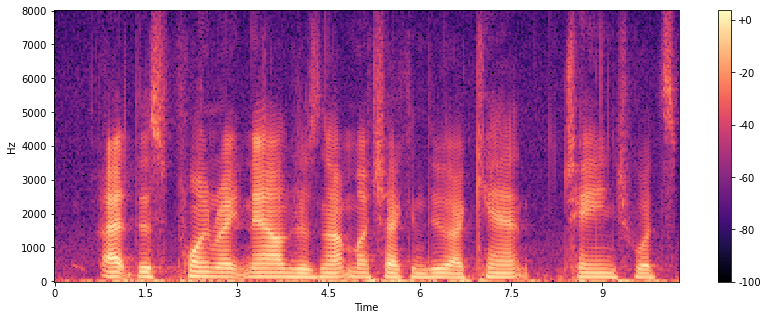

Label: 0


In [12]:
if __name__ == "__main__":
    partition = "train"
    METADATA_FILE = f"data/processed/labels/{partition}_metadata.csv"
    AUDIO_DIR = "data/raw/audio"
    TRANSCRIPTS_DIR = "data/processed/transcripts"
    MEL_SPECTROGRAM = True

    local_device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device {local_device}")

    dwd = DaicWozDataset("train", MEL_SPECTROGRAM, METADATA_FILE, AUDIO_DIR, TRANSCRIPTS_DIR, local_device)

    print(f"There are {len(dwd)} samples in the dataset.")
    ind = random.randint(0, len(dwd))
    print(f"The sample {ind} has been randomly selected")
    spectrogram, label = dwd[ind]
    print("Spectrogram:")
    spectrogram = spectrogram.numpy()[0]
    show_spectrogram(spectrogram, y_axis="linear")
    print("Label:", label)


Using device cpu
There are 3707176 samples in the dataset.
The sample 3635296 has been randomly selected
Spectrogram:


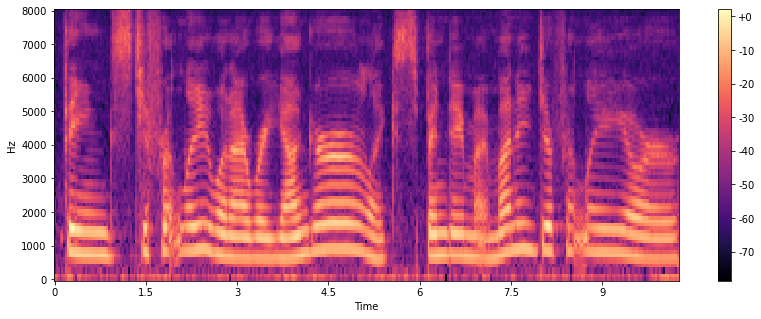

Label: 0
Using device cpu
There are 5208285 samples in the dataset.
The sample 4863279 has been randomly selected
Spectrogram:


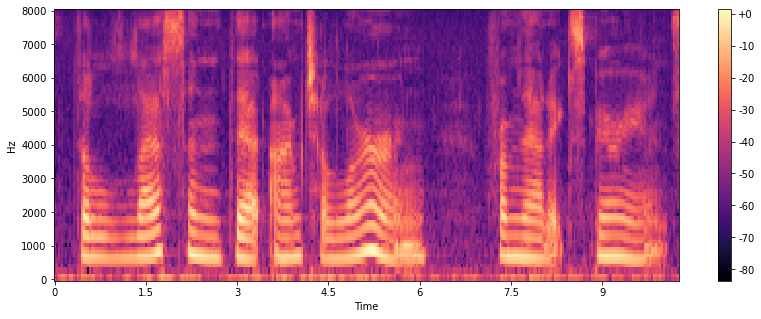

Label: 0
Using device cpu
There are 7216951 samples in the dataset.
The sample 4060112 has been randomly selected


ValueError: can only convert an array of size 1 to a Python scalar

In [9]:
if __name__ == "__main__":
    for partition in ["train", "dev", "test"]:
        METADATA_FILE = "data/raw/labels/metadata.csv"
        AUDIO_DIR = "data/raw/audio"
        TRANSCRIPTS_DIR = "data/processed/transcripts"
        MEL_SPECTROGRAM = True

        local_device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device {local_device}")

        dwd = DaicWozDataset(partition, MEL_SPECTROGRAM, METADATA_FILE, AUDIO_DIR, TRANSCRIPTS_DIR, local_device)

        print(f"There are {len(dwd)} samples in the dataset.")
        ind = random.randint(0, len(dwd))
        print(f"The sample {ind} has been randomly selected")
        spectrogram, label = dwd[ind]
        print("Spectrogram:")
        spectrogram = spectrogram.numpy()[0]
        show_spectrogram(spectrogram, y_axis="linear")
        print("Label:", label)
